## Immunosuppressive paths between PDL1 and CD8 T cells in BC datasets
<br>
<b>Description</b> : In this notebook we tried to use the cell-cell interaction output of breast cancer datasets
to plot the PDL1-related immunosuppressive paths given by figure 4. The coefficients are calculated by subtracting CD8 T cells <-- PDL1+ cancer epithelial by CD8 T cells <-- PDL1- cancer epithelial.<br>
<b>Author</b> : Hejin Huang (huang.hejin@gene.com)<br>

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

In [3]:
# Path to the interaction data files
data_folder = '../../data/analysis/bc/PDL1_cancer/'

# List of patient IDs
patient_ids = ['CID4290', 'CID4535', 'CID4465', 'CID44971']

# Load differential gene expression data for each patient
de_genes_data = []
for p_id in patient_ids:
    de_genes_data.append(pd.read_csv(data_folder + p_id + '.csv', index_col=0))

In [4]:
# Define receiver and signaler cell types
receiver_cell_types = ['T cells CD8+', 'T-regs', 'Cancer Epithelial', 'Macrophage', 'PDL1_cancer']
signaler_cell_types = ['Macrophage', 'T-regs', 'CAFs', 'Cancer Epithelial', 'PDL1_cancer']

# Generate all possible interactions
all_interactions = []
for r_type in receiver_cell_types:
    for s_type in signaler_cell_types:
        all_interactions.append(r_type + '_vs_' + s_type)

# Define marker gene lists
tregs_markers = [i.lower() for i in ['ENTPD1', 'IL10', 'GZMB', 'TGFB1', 'CTLA4', 'LAG3', 'PRF1', 'NRP1', 'TIGIT']]
exhaustion_markers = [i.lower() for i in ['TOX', 'CTLA4', 'PDCD1', 'LAG3', 'HAVCR2', 'TIGIT', 'IFNG', 'IL2', 'HIF1A']]
macrophages_markers = [i.lower() for i in ['CD80', 'CD86', 'CCR7', 'IFNG', 'CD40', 'HLA-DRA', 'HLA-DRB1', 'IL10', 'IL4', 'CD274']]
cafs_markers = ['cd274', 'pdcd1lg2', 'ido1', 'lilrb4', 'lilrb2', 'cd276', 'c10orf54', 'lgals9', 'tnfrsf14']

# Combine all marker genes into a single list
all_markers = (tregs_markers + exhaustion_markers + macrophages_markers + cafs_markers)

In [5]:
# --- Process Differential Gene Expression Data ---
# Dictionary to store comparison DataFrames for each interaction
interaction_comparison_results = dict()

for interact_type in all_interactions:
    current_interaction_df = pd.DataFrame()
    for i in range(len(de_genes_data)):
        beta_df = de_genes_data[i].copy() # Create a copy to avoid SettingWithCopyWarning
        
        # Filter beta_df for the current interaction and marker genes
        # Use .loc for explicit indexing and .copy() to ensure a new DataFrame
        filtered_result_df = beta_df.loc[(beta_df['inter'] == interact_type) & 
                                         (beta_df['features'].isin(all_markers))].copy()
        
        # Add patient ID to the filtered DataFrame
        filtered_result_df['patient'] = patient_ids[i]
        
        # Concatenate with the DataFrame for the current interaction type
        current_interaction_df = pd.concat([current_interaction_df, filtered_result_df])
            
    interaction_comparison_results[interact_type] = current_interaction_df.copy()


In [6]:
# Concatenate all interaction comparison results into a single DataFrame
all_results_df = pd.DataFrame()
for key in interaction_comparison_results.keys():
    all_results_df = pd.concat([all_results_df, interaction_comparison_results[key]])

# Create a copy and set index for further processing
processed_results_df = all_results_df.copy()
processed_results_df.index = processed_results_df.features

# --- Generate Comparison DataFrame for Specific Interaction ---
# Define specific signaler and receiver for this comparison
signaler_type_1 = 'Cancer Epithelial'
signaler_type_2 = 'PDL1_cancer'
receiver_type = 'T cells CD8+'

comparison_df = pd.DataFrame()

In [7]:
# Loop through patients, starting from the third one (index 2) as per original notebook logic
# Assuming this slice [2:] is intentional for specific patient analysis.
for pat_id in processed_results_df['patient'].unique()[2:]:
    # Filter for the specific interaction and patient, then extract 'beta' values for positive and negative
    positive_beta_values = processed_results_df[(processed_results_df['inter'] == receiver_type + '_vs_' + signaler_type_2) & 
                                                  (processed_results_df['patient'] == pat_id)]['beta'] 
    negative_beta_values = processed_results_df[(processed_results_df['inter'] == receiver_type + '_vs_' + signaler_type_1) & 
                                                  (processed_results_df['patient'] == pat_id)]['beta']  
    
    # Calculate the difference between positive and negative beta values
    comparison_df[pat_id] = positive_beta_values - negative_beta_values

# --- Prepare Data for Heatmap Plotting ---
comparison_df.index = comparison_df.index.str.upper() # Convert index to uppercase

# The gene_list here is 'exhausion', specific to this plot
gene_list_for_heatmap = exhaustion_markers

# Convert gene_list to uppercase for comparison with DataFrame index
comparison_set = [gene.upper() for gene in gene_list_for_heatmap]

# Find genes that are common between the comparison_set and the DataFrame index
intersect_genes_for_heatmap = []
for gene_name in comparison_set:
    if gene_name in comparison_df.index:
        intersect_genes_for_heatmap.append(gene_name)

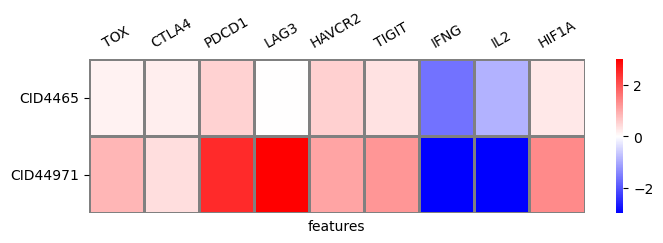

In [8]:
# --- Plotting ---
plt.figure(figsize=(8, 2)) # Set figure size

# Generate and display the heatmap
sns.heatmap(comparison_df.loc[intersect_genes_for_heatmap].T, 
            cmap='bwr', 
            center=0, 
            vmin=-3.0, 
            vmax=3.0, 
            linewidths=1, 
            linecolor='grey')

plt.yticks(rotation=0) # Rotate y-axis labels
plt.xticks(fontsize=18) # Set x-axis font size
plt.tick_params(labelbottom=False, bottom=False, top=False, labeltop=True) # Hide bottom labels and ticks, show top labels
plt.xticks(rotation=30) # Rotate x-axis labels
plt.show() # Display the plot